In [1]:
%matplotlib inline
from pylab import *

- Blur of 4 is not enough to reproduce the deficit given the retinal normalization.
- Blur of 8 is more than enough to reproduce the deficit given the retinal normalization.

In [2]:
from deficit_defs import *

Splikes version  0.1.2
Plasticnet version  0.1.9
macOS-10.16-x86_64-i386-64bit
Base Image File: asdf/bbsk081604_all_log2dog.asdf


In [3]:
def savefig(base):
    import matplotlib.pyplot as plt
    for fname in [f'Manuscript/resources/{base}.png',f'Manuscript/resources/{base}.svg']:
        print(fname)
        plt.savefig(fname, bbox_inches='tight')

In [4]:
_debug = False
if _debug:
    print("Debugging")

In [5]:
base='sims/2023-02-20'
if not os.path.exists(base):
    print(f"mkdir {base}")
    os.mkdir(base)

mkdir sims/2023-02-20


In [6]:
def blur_jitter_deficit(blur=[2.5,-1],
                        noise=[0.1,.1],
                        rf_size=19,eta=2e-6,
                        mu_c=0,sigma_c=1,    
                        mu_r=0,sigma_r=1,
                        number_of_neurons=10,
                        total_time=8*day,
                        save_interval=1*hour):

    
    if _debug:
        total_time=1*minute
        save_interval=1*second
        
    images=[]
    dt=200*ms
    
    for bv in blur:
        if bv<=0:
            im=pi5.filtered_images(
                                base_image_file,
                                {'type':'dog','sd1':1,'sd2':3},
                                {'type':'norm'},
                                )
        else:
            im=pi5.filtered_images(
                                    base_image_file,
                                    {'type':'blur','size':bv},
                                    {'type':'dog','sd1':1,'sd2':3},
                                    {'type':'norm'},
                                    )
        images.append(im)
        
        
    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(images[0],
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=1,
                                                sigma_c=1,
                                                verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(images[1],
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)



    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=dt

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]

In [7]:
def run_one(params,overwrite=False):
    import plasticnet as pn
    count,eta,noise,blur,number_of_neurons,sfname,mu_c,sigma_c=(params.count,params.eta,params.noise,params.blur,
                                        params.number_of_neurons,params.sfname,params.mu_c,params.sigma_c)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    seq=pn.Sequence()

    t=16*day*2
    ts=1*hour

    # DEBUG
    if _debug:
        t=1*minute
        ts=1*second
    
    seq+=blur_jitter_deficit(blur=[blur,-1],
                                total_time=t,
                                noise=noise,eta=eta,number_of_neurons=number_of_neurons,
                                mu_c=mu_c,sigma_c=sigma_c,
                                save_interval=ts)

    
    seq.run(display_hash=False)
    pn.save(sfname,seq) 
    
    return sfname
    


In [28]:
from collections import namedtuple
params = namedtuple('params', ['count', 'eta','noise','blur','number_of_neurons','sfname','mu_c','sigma_c'])

do_params=[
    
    params(count=0,
         eta=2e-6,
         blur=6,
         noise=0.0,
         number_of_neurons=20,
         sfname=f'{base}/test.asdf',
         mu_c=7.5,
         sigma_c=2,
          ),
]



In [29]:
run_one(do_params[0],overwrite=True)

 [#############################100% (ETA: 0.0 s)#############################]
Saving cache_images/cache_images_507df59dc6ac457d8c54d9fa2b1111e2.asdf...Resolution float64 -> uint16
done.
Using cache_images/cache_images_395ed573cbab94baa435fdeb1e2b01d2.asdf from cache.[.] Sequence Time Elapsed...11 m, 59.23 s


'sims/2023-02-20/test.asdf'

In [30]:
sfname=do_params[0].sfname

In [31]:
R=Results(sfname)

/Users/bblais/tmp/ipykernel_84023/1350155651.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pcolormesh(w_im[n,c,...],cmap=py.cm.gray,


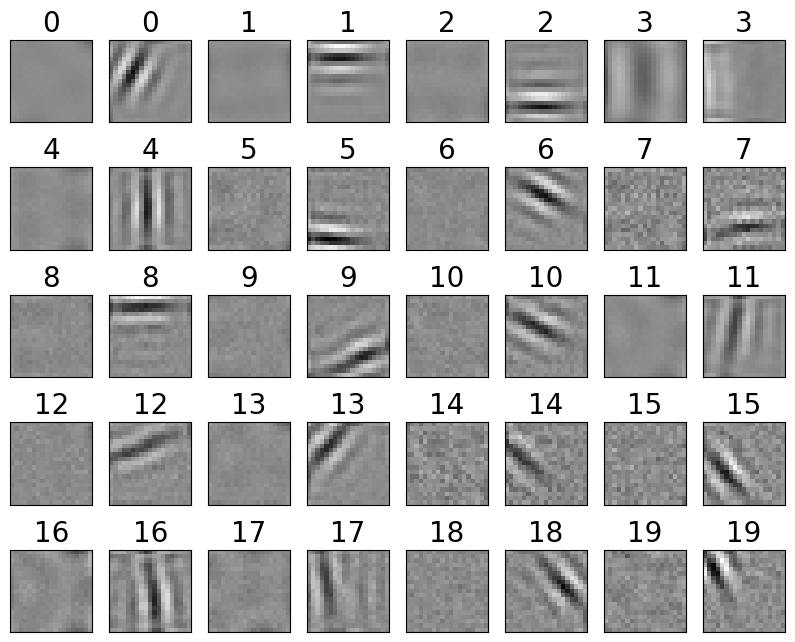

In [32]:
t,y,θ,W=R[16*day]
vmin=W.min()
vmax=W.max()

w_im=R.weight_image(W)
count=1
for n in range(20):
    for c in range(2):
        subplot(5,8,count)
        pcolormesh(w_im[n,c,...],cmap=py.cm.gray,
                        vmin=vmin,vmax=vmax)
        ax2=gca()
        ax2.set_aspect('equal')
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.xaxis.set_ticks_position('none') 
        ax2.yaxis.set_ticks_position('none') 
        title(n)
        count+=1


In [33]:
weak_i=0
strong_i=1

sims/2023-02-20/test.asdf


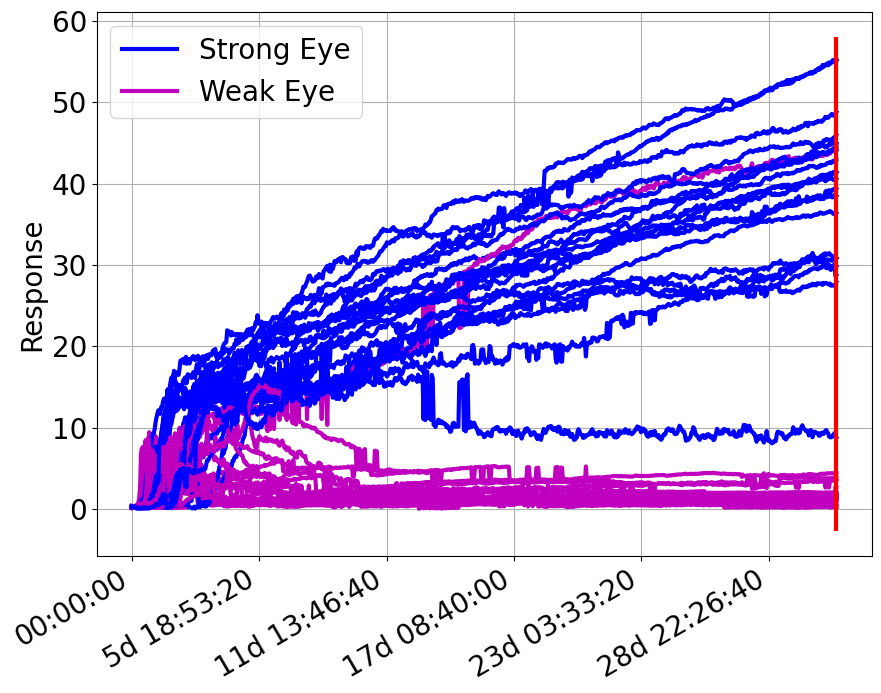

In [34]:
plot(R.t,R.y[:,0,strong_i],'b',label='Strong Eye')
plot(R.t,R.y[:,0,weak_i],'m',label='Weak Eye')

for n in range(20):
    plot(R.t,R.y[:,n,0],'m')
    plot(R.t,R.y[:,n,1],'b')
    
yl=gca().get_ylim()
vlines(R.sequence_times[0][1],yl[0],yl[1],'r')
    
ylabel('Response')
legend()
print(sfname)
reformat_time_axis()    

In [35]:
R.sequence_times

[(0.0, 2764800.000277126)]